In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('media.csv', index_col=['date'])
prices.head(10)

ZEEL.NS       PVR.NS     SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  \
date                                                                           
01-01-2018  579.200012  1423.750000   998.000000   814.650024      60.700001   
02-01-2018  578.150024  1402.800049   995.200012   792.799988      59.950001   
03-01-2018  579.750000  1401.800049  1004.700012   853.400024      60.500000   
04-01-2018  580.000000  1399.000000  1028.199951   840.250000      60.000000   
05-01-2018  586.849976  1419.000000  1037.949951   832.700012      63.599998   
08-01-2018  593.900024  1460.199951  1044.449951   816.549988      64.250000   
09-01-2018  580.049988  1486.800049  1032.750000   853.700012      62.650002   
10-01-2018  580.500000  1469.000000  1022.150024   829.250000      62.099998   
11-01-2018  580.000000  1460.750000  1043.599976   828.900024      61.900002   
12-01-2018  591.000000  1463.150024  1077.099976   840.000000      66.050003   

            INOXLEISUR.NS  DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
date                                                            
01-01-2018     287.200012  81.699997     59.849998   39.599998  
02-01-2018     280.850006  85.000000     58.950001   39.450001  
03-01-2018     281.000000  85.050003     58.849998   39.799999  
04-01-2018     281.750000  84.550003     60.250000   39.750000  
05-01-2018     287.850006  84.650002     60.599998   40.000000  
08-01-2018     290.799988  85.449997     61.000000   39.799999  
09-01-2018     294.399994  86.199997     60.200001   39.200001  
10-01-2018     287.000000  84.699997     59.099998   39.099998  
11-01-2018     289.000000  83.750000     60.349998   40.299999  
12-01-2018     285.950012  78.099998     62.349998   40.599998

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

ZEEL.NS       PVR.NS    SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  \
date                                                                          
01-01-2018  579.200012  1423.750000  998.000000   814.650024      60.700001   
02-01-2018  578.150024  1402.800049  995.200012   792.799988      59.950001   
30-12-2020  219.149994  1290.000000  480.500000   814.799988      31.049999   
31-12-2020  223.500000  1320.199951  480.750000   835.450012      30.900000   

            INOXLEISUR.NS  DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
date                                                            
01-01-2018     287.200012  81.699997     59.849998   39.599998  
02-01-2018     280.850006  85.000000     58.950001   39.450001  
30-12-2020     280.750000  13.350000     36.150002   32.700001  
31-12-2020     282.299988  13.400000     35.900002   33.150002

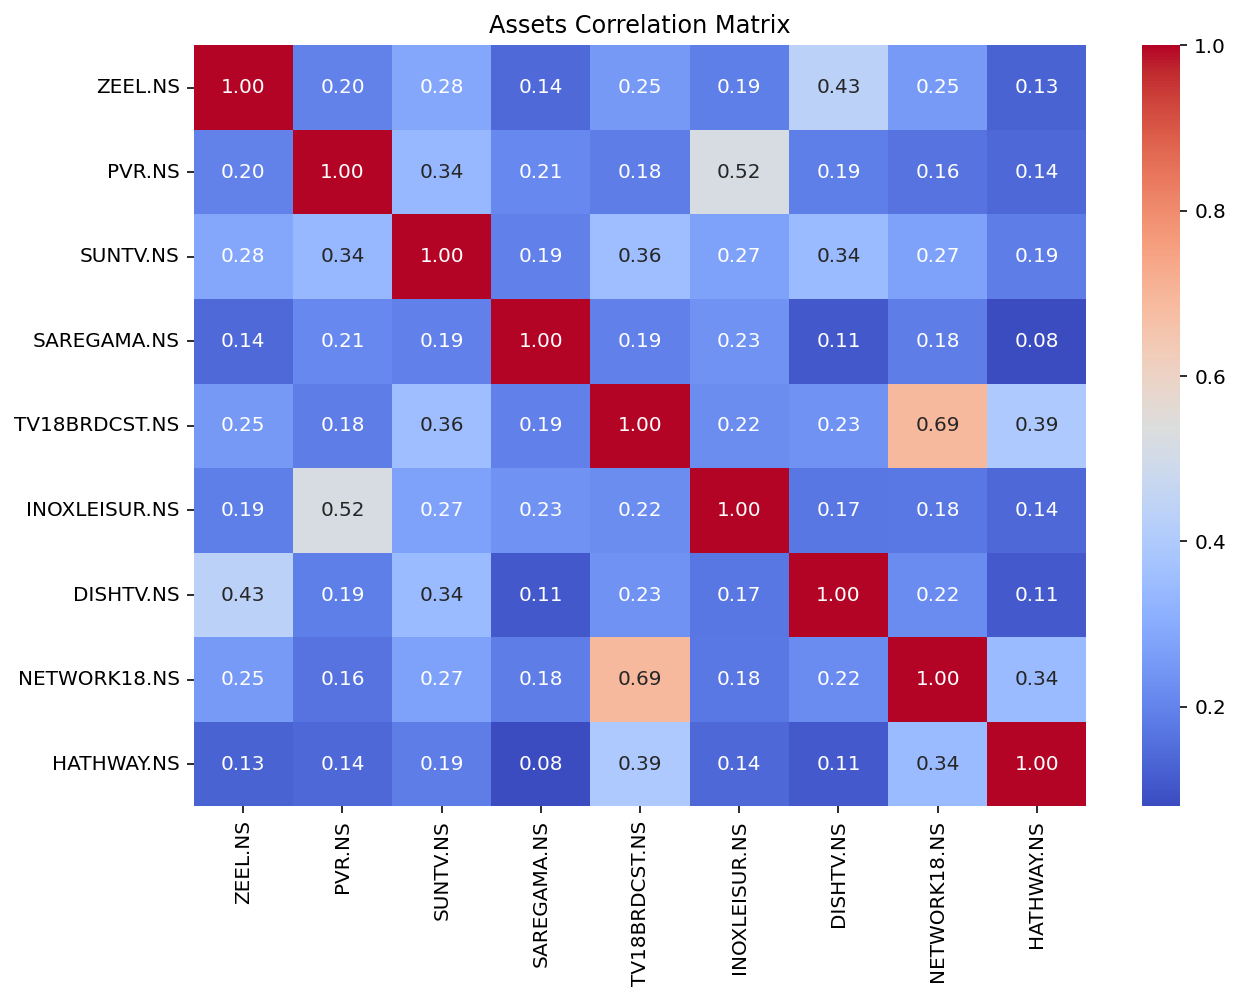

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('SUNTV.NS', 'DISHTV.NS')]


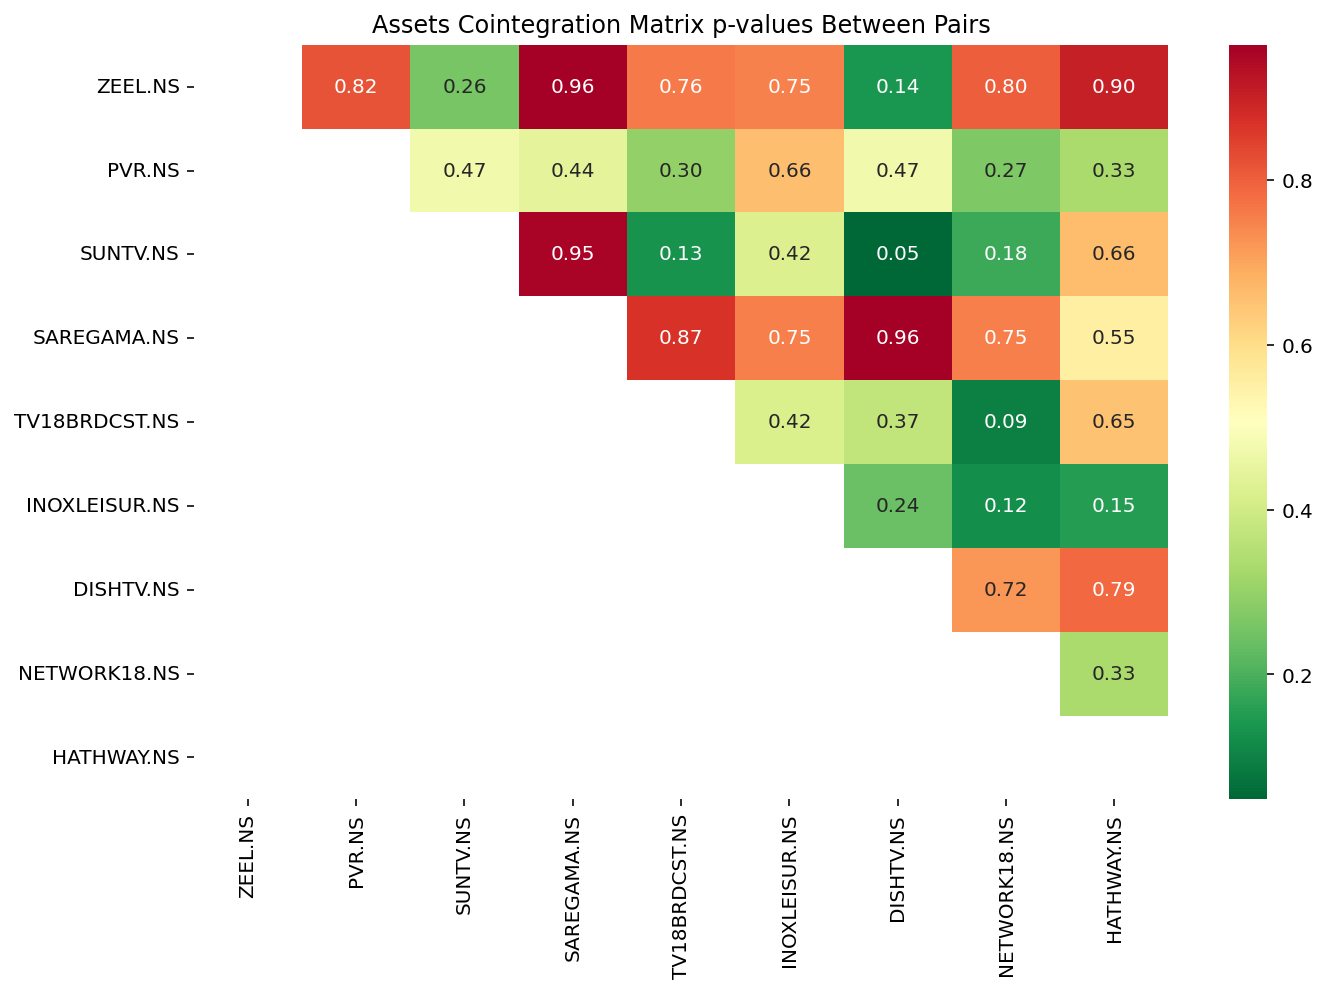

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'PVR.NS'
asset2 = 'INOXLEISUR.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

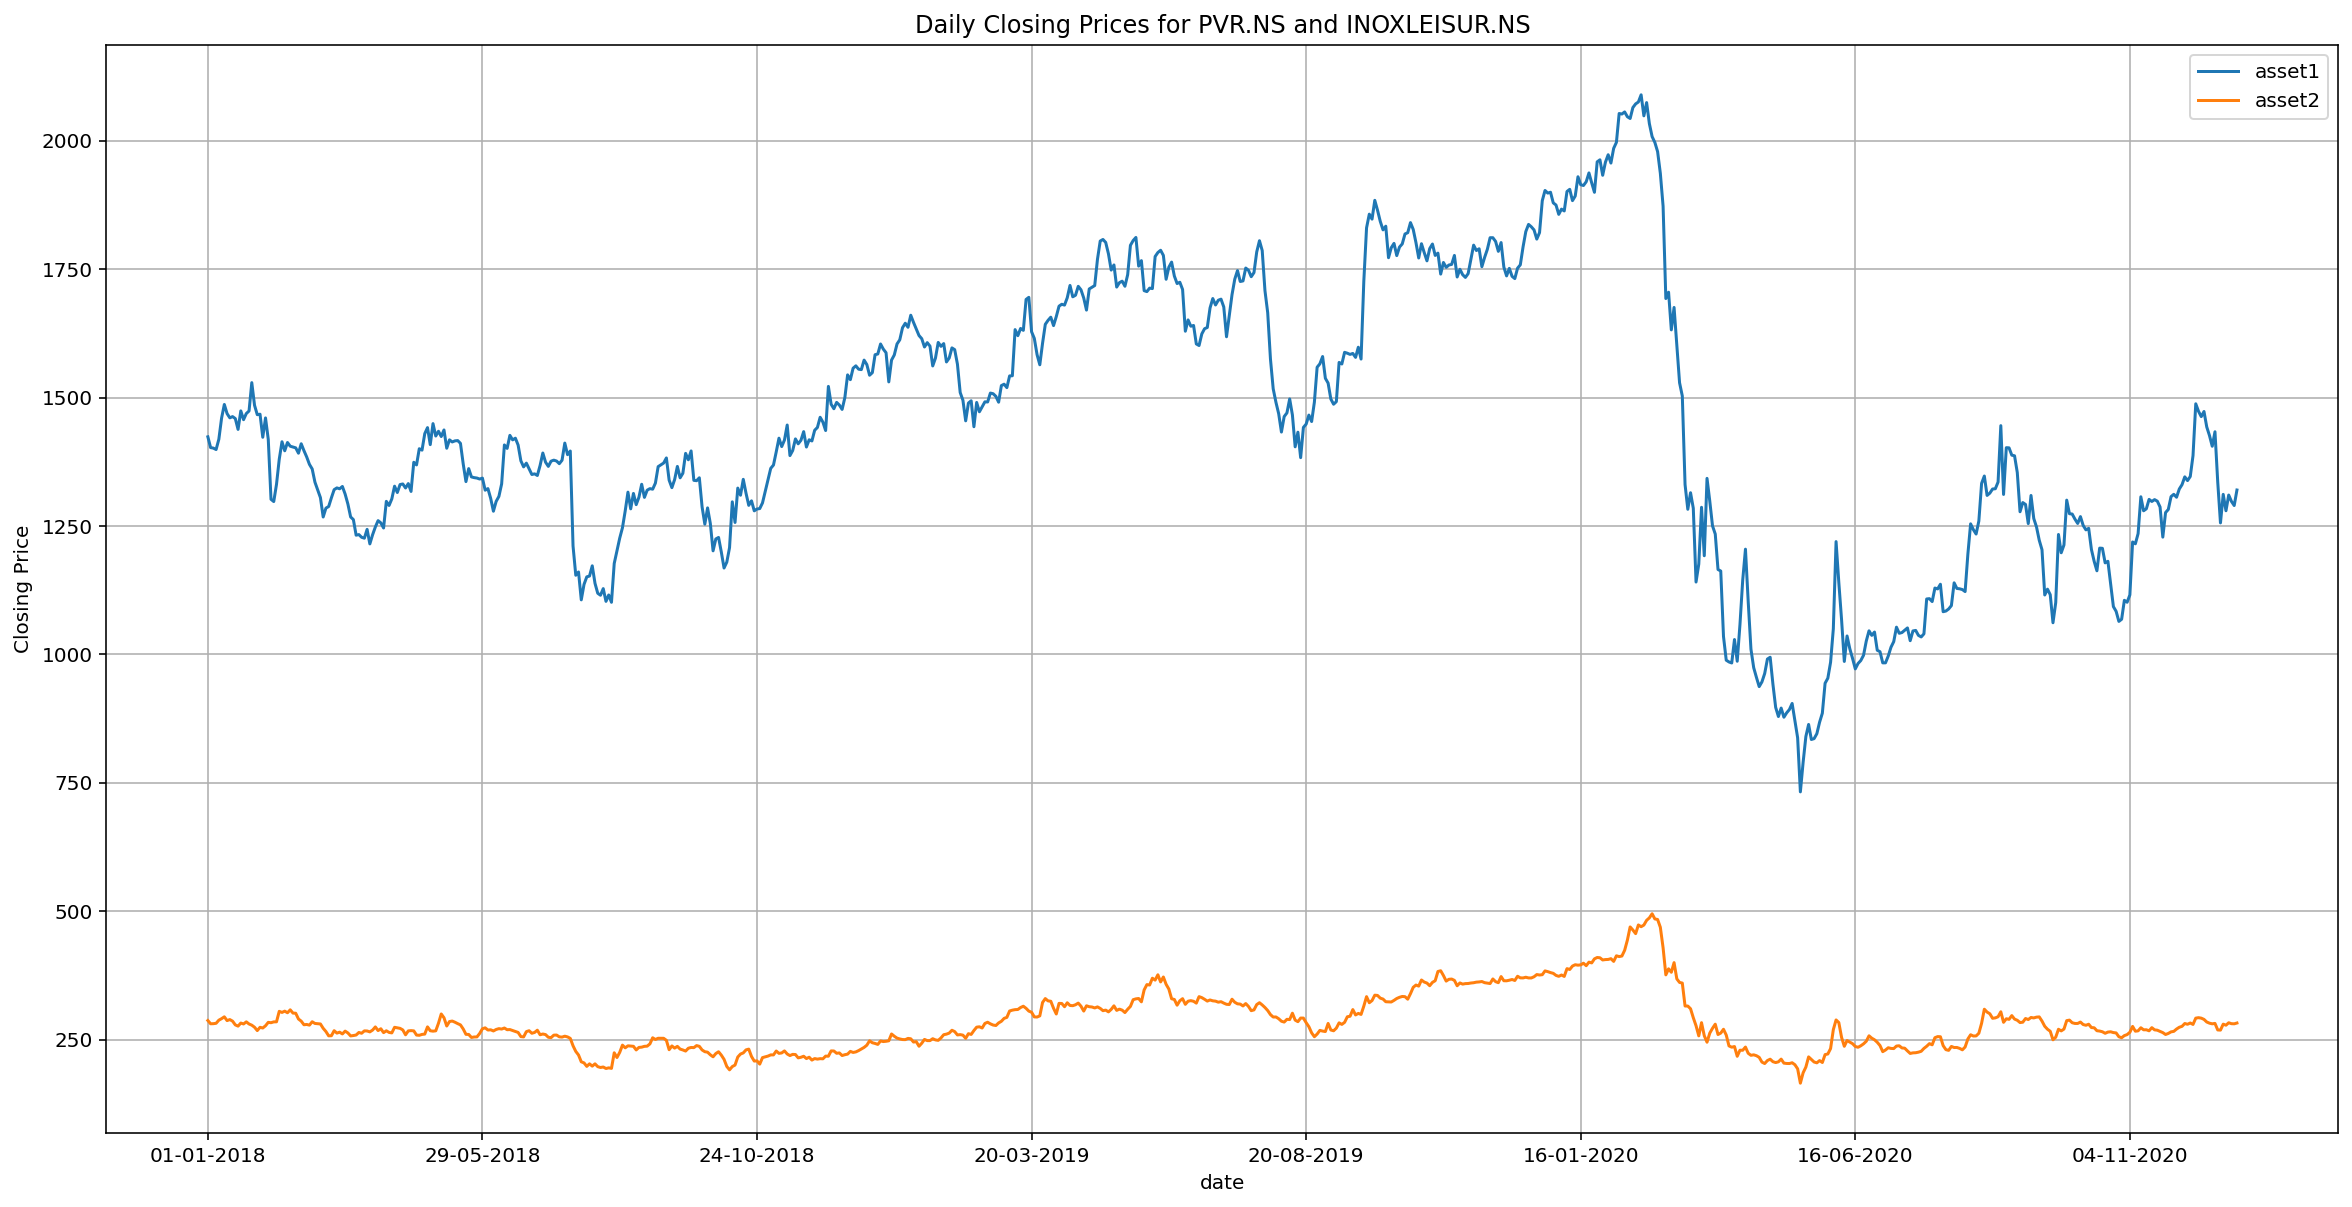

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          5.614e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:51:53   Log-Likelihood:                         -3636.1
No. Observations:                 740   AIC:                                      7274.
Df Residuals:                     739   BIC:                                      7279.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.1957      0.001    236.930      0.000       0.194       0.197
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.857
Skew:                          -0.281   Prob(JB):                      0.00724
Kurtosis:                       2.933   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

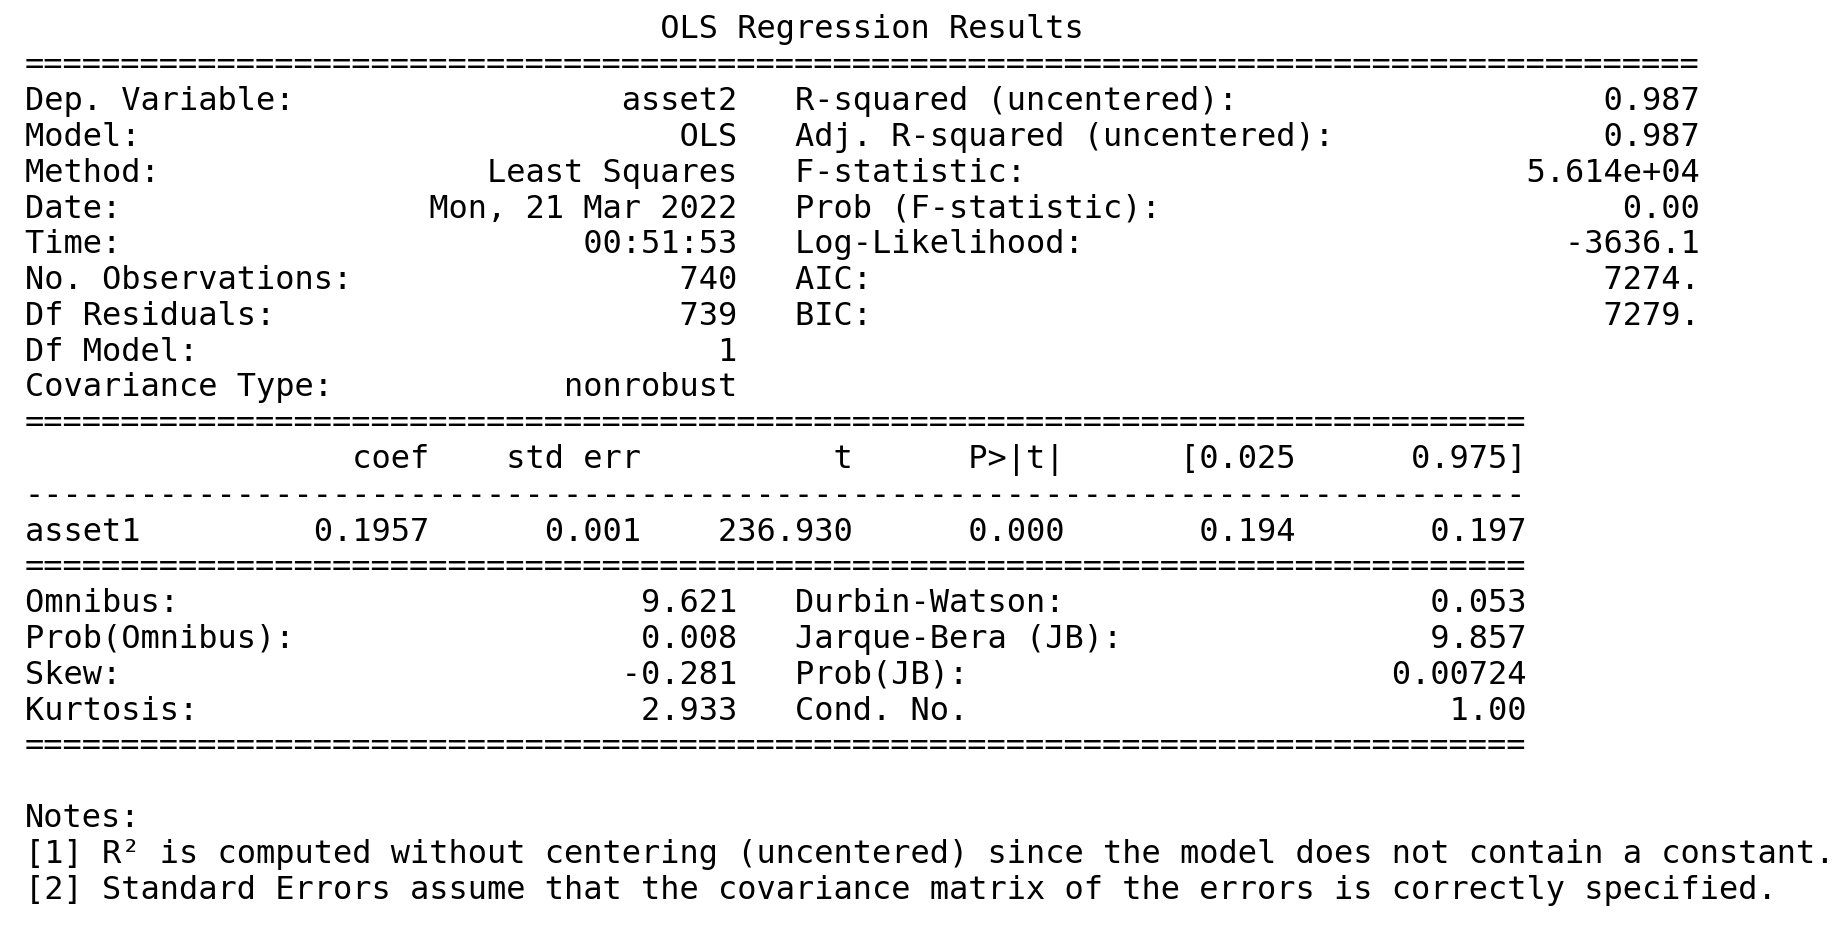

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.19568909843748505


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

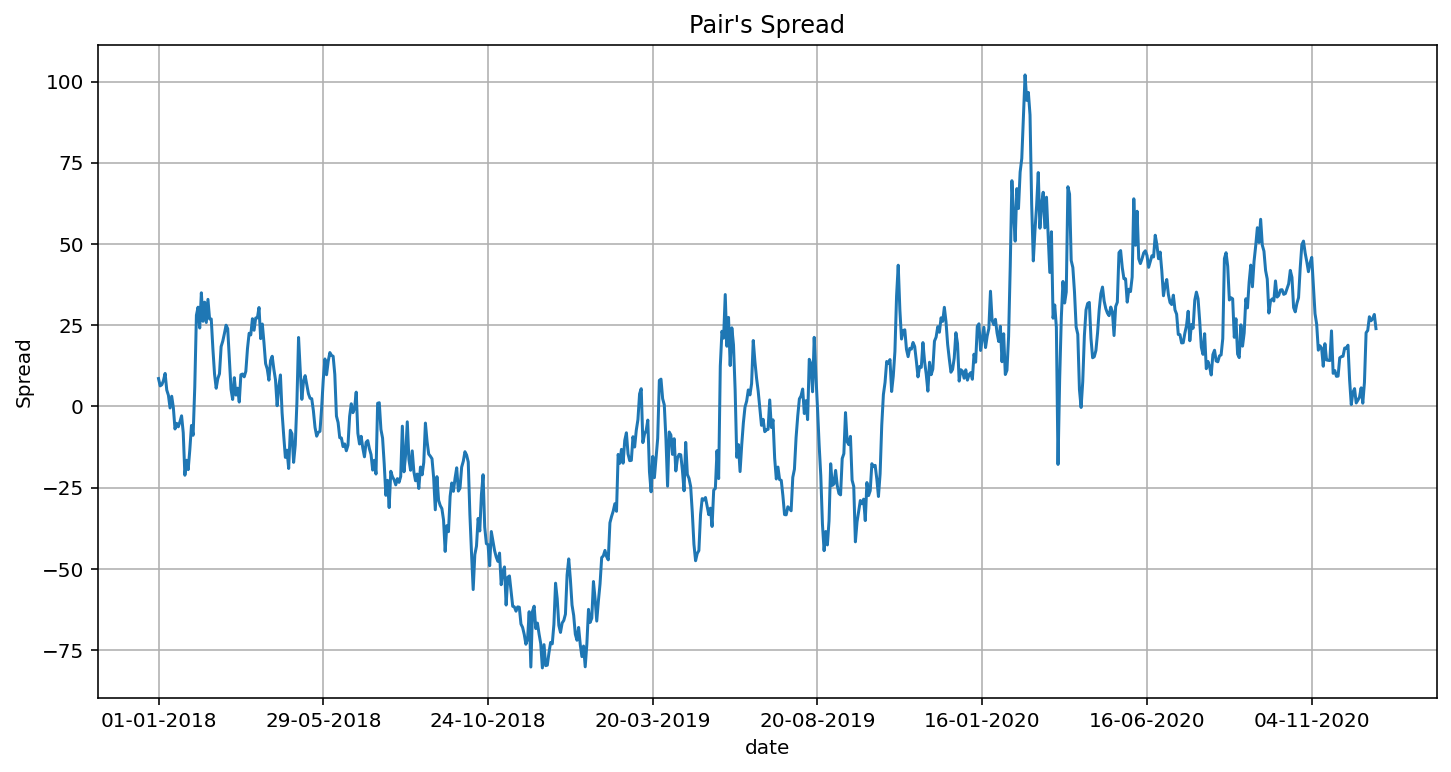

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.127706992846814,
 0.02456954369607516,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 5086.318245666606)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.127706992846814


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  1340.349976  286.850006
04-01-2021  1399.000000  303.899994
05-01-2021  1416.699951  315.000000
06-01-2021  1438.099976  333.549988
07-01-2021  1434.000000  326.649994

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  1340.349976  286.850006  1.533114            1.0           -1.0
04-01-2021  1399.000000  303.899994  1.292669            1.0           -1.0
05-01-2021  1416.699951  315.000000  0.924063            1.0           -1.0
06-01-2021  1438.099976  333.549988  0.277565            1.0           -1.0
07-01-2021  1434.000000  326.649994  0.550548            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

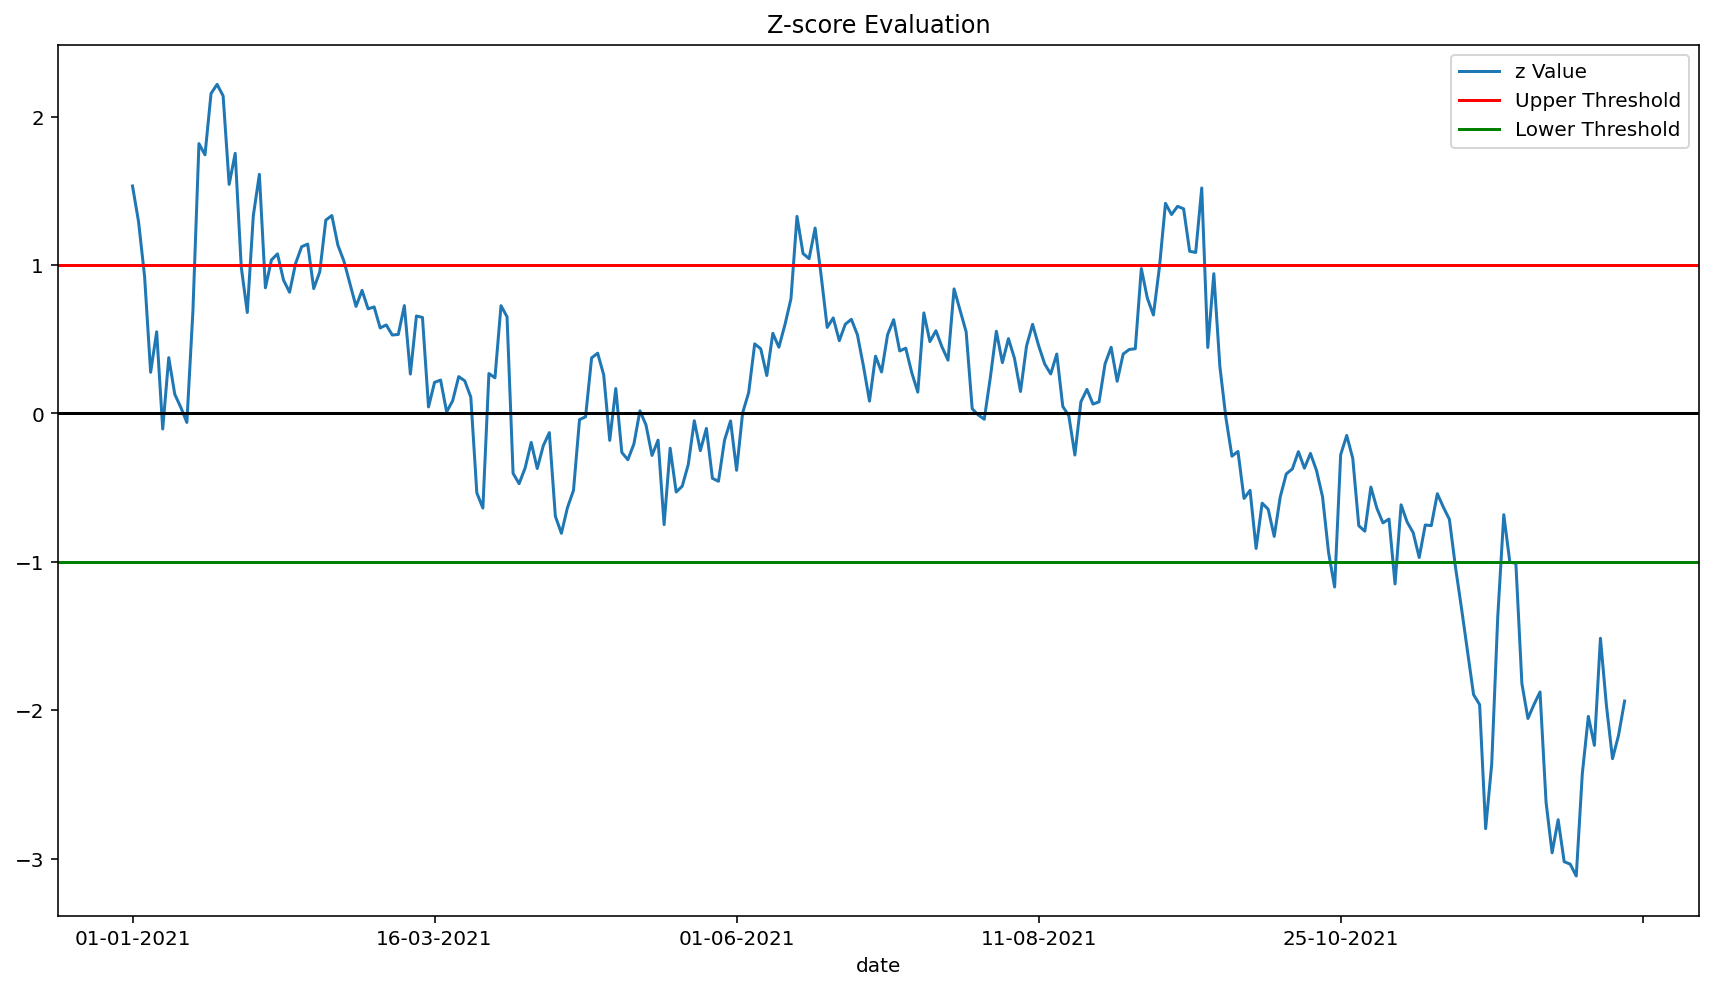

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1340.349976  286.850006  1.533114            1.0           -1.0   
04-01-2021  1399.000000  303.899994  1.292669            1.0           -1.0   
05-01-2021  1416.699951  315.000000  0.924063            1.0           -1.0   
29-12-2021  1260.949951  353.950012 -2.326292            1.0           -1.0   
30-12-2021  1273.400024  352.950012 -2.168571            1.0           -1.0   
31-12-2021  1298.300049  353.350006 -1.937786            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1340.349976  286.850006  1.533114            1.0           -1.0   
04-01-2021  1399.000000  303.899994  1.292669            1.0           -1.0   
18-01-2021  1499.400024  315.350006  1.818416            1.0           -1.0   
19-01-2021  1519.300049  321.000000  1.742993            1.0           -1.0   
20-01-2021  1564.949951  322.549988  2.155945            1.0           -1.0   
21-01-2021  1545.849976  317.450012  2.217756            1.0           -1.0   
22-01-2021  1519.650024  313.500000  2.140518            1.0           -1.0   
25-01-2021  1462.800049  312.850006  1.543794            1.0           -1.0   
27-01-2021  1478.349976  312.149994  1.753431            1.0           -1.0   
01-02-2021  1521.849976  329.750000  1.333257            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
18-01-2021        -1        -1.0         1         1.0  
19-01-2021        -1         0.0         1         0.0  
20-01-2021        -1         0.0         1         0.0  
21-01-2021        -1         0.0         1         0.0  
22-01-2021        -1         0.0         1         0.0  
25-01-2021        -1         0.0         1         0.0  
27-01-2021        -1         0.0         1         0.0  
01-02-2021        -1        -1.0         1         1.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1340.349976  286.850006  1.533114            1.0           -1.0   
05-01-2021  1416.699951  315.000000  0.924063            1.0           -1.0   
18-01-2021  1499.400024  315.350006  1.818416            1.0           -1.0   
28-01-2021  1449.099976  320.899994  0.987603            1.0           -1.0   
01-02-2021  1521.849976  329.750000  1.333257            1.0           -1.0   
08-11-2021  1803.699951  462.350006 -1.148983            1.0           -1.0   
09-11-2021  1792.949951  442.200012 -0.615493            1.0           -1.0   
23-11-2021  1603.400024  407.549988 -1.033965            1.0           -1.0   
03-12-2021  1442.099976  357.350006 -0.681803            1.0           -1.0   
06-12-2021  1350.650024  342.500000 -1.001764            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-01-2021         0         1.0         0        -1.0  
18-01-2021        -1        -1.0         1         1.0  
28-01-2021         0         1.0         0        -1.0  
01-02-2021        -1        -1.0         1         1.0  
08-11-2021         1         1.0        -1        -1.0  
09-11-2021         0        -1.0         0         1.0  
23-11-2021         1         1.0        -1        -1.0  
03-12-2021         0        -1.0         0         1.0  
06-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

1416.699951    1
1449.099976    1
1506.150024    1
1519.699951    1
1471.650024    1
1374.400024    1
1379.300049    1
1568.349976    1
1627.449951    1
1803.699951    1
1603.400024    1
1350.650024    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  1340.349976  286.850006  1.533114            1.0           -1.0   
04-01-2021  1399.000000  303.899994  1.292669            1.0           -1.0   
05-01-2021  1416.699951  315.000000  0.924063            1.0           -1.0   
06-01-2021  1438.099976  333.549988  0.277565            1.0           -1.0   
07-01-2021  1434.000000  326.649994  0.550548            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  1334.650024  351.600006 -1.514794            1.0           -1.0   
28-12-2021  1285.199951  350.700012 -1.971127            1.0           -1.0   
29-12-2021  1260.949951  353.950012 -2.326292            1.0           -1.0   
30-12-2021  1273.400024  352.950012 -2.168571            1.0           -1.0   
31-12-2021  1298.300049  353.350006 -1.937786            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

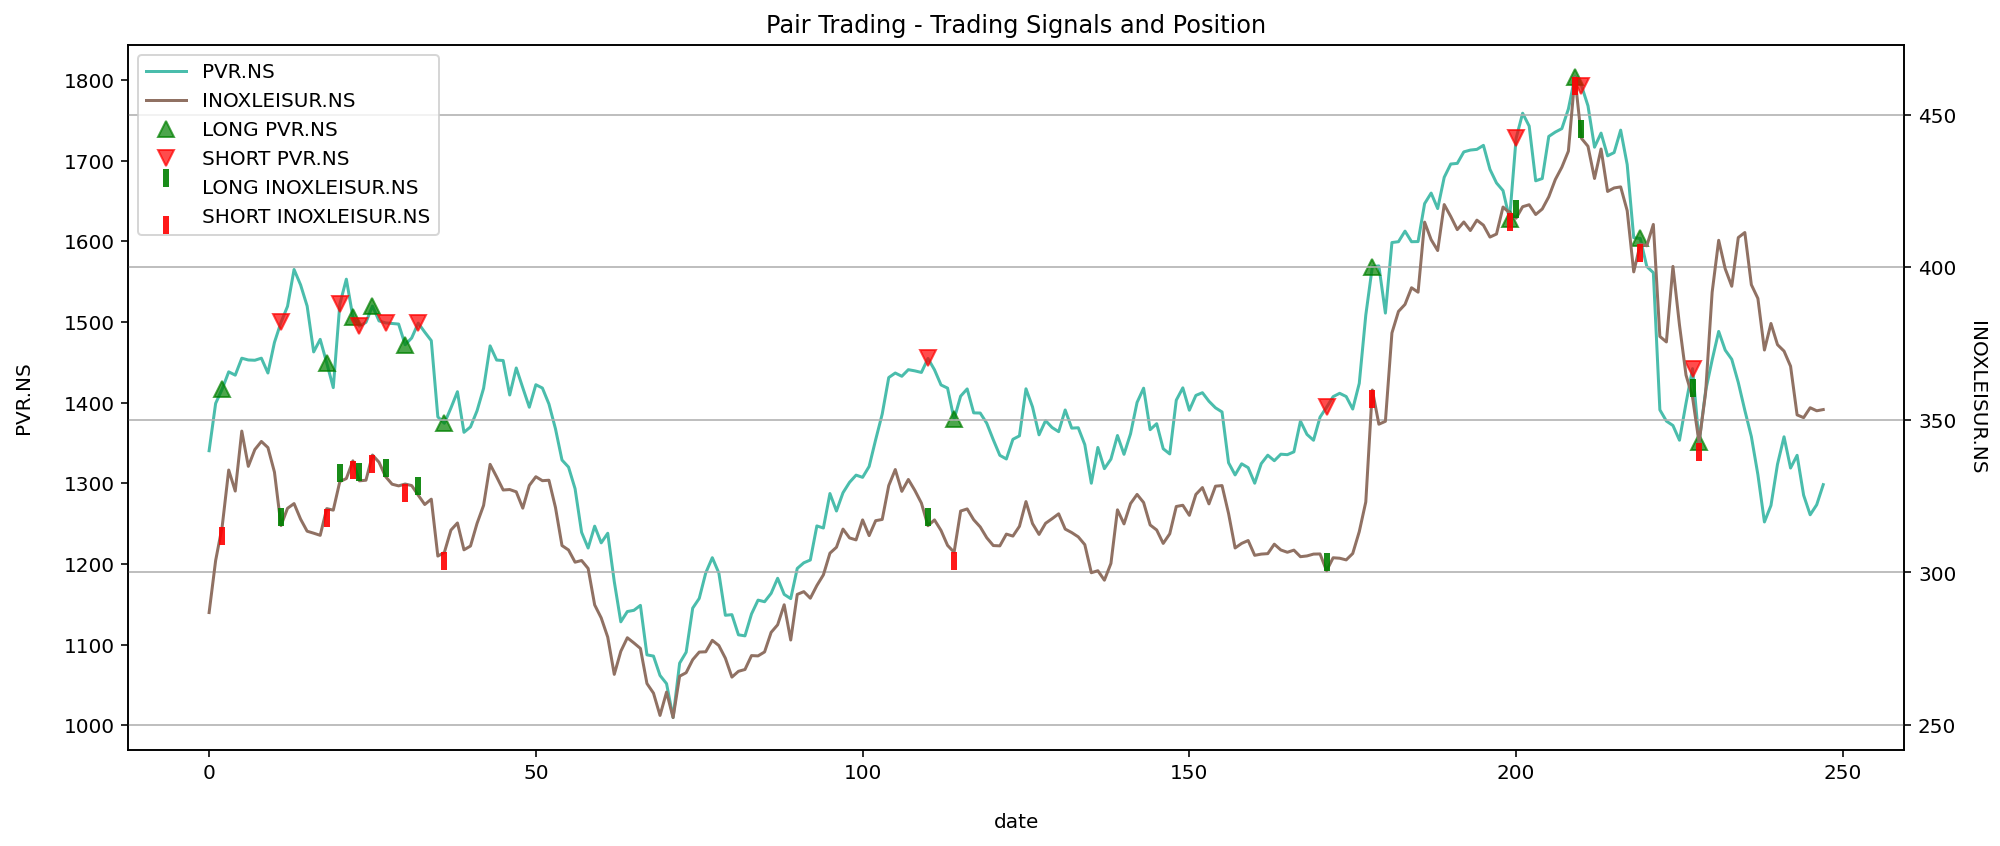

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    1340.349976            NaN            NaN            NaN       NaN   
1    1399.000000       0.000000  100000.000000  100000.000000       NaN   
2    1416.699951   77918.497305   22081.502695  100000.000000  0.000000   
3    1438.099976   79095.498680   22081.502695  101177.001375  0.011770   
4    1434.000000   78870.000000   22081.502695  100951.502695 -0.002229   
243  1334.650024  146811.502640  -51024.501265   95787.001375  0.018420   
244  1285.199951  141371.994610  -51024.501265   90347.493345 -0.056788   
245  1260.949951  138704.494610  -51024.501265   87679.993345 -0.029525   
246  1273.400024  140074.002640  -51024.501265   89049.501375  0.015619   
247  1298.300049  142813.005390  -51024.501265   91788.504125  0.030758   

     positions1  
0           NaN  
1           0.0  
2           1.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1340.349976           NaN            NaN            NaN       NaN   
2   1416.699951  77918.497305   22081.502695  100000.000000  0.000000   
11  1499.400024      0.000000  104548.504015  104548.504015  0.013219   
18  1449.099976  79700.498680   24848.005335  104548.504015  0.000000   
20  1521.849976      0.000000  108549.754015  108549.754015  0.055231   

    positions1  
0          NaN  
2          1.0  
11        -1.0  
18         1.0  
20        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    1340.349976            NaN            NaN            NaN       NaN   
1    1399.000000       0.000000  100000.000000  100000.000000       NaN   
2    1416.699951   77918.497305   22081.502695  100000.000000  0.000000   
3    1438.099976   79095.498680   22081.502695  101177.001375  0.011770   
4    1434.000000   78870.000000   22081.502695  100951.502695 -0.002229   
243  1334.650024  146811.502640  -51024.501265   95787.001375  0.018420   
244  1285.199951  141371.994610  -51024.501265   90347.493345 -0.056788   
245  1260.949951  138704.494610  -51024.501265   87679.993345 -0.029525   
246  1273.400024  140074.002640  -51024.501265   89049.501375  0.015619   
247  1298.300049  142813.005390  -51024.501265   91788.504125  0.030758   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  286.850006            NaN            NaN            NaN   
1           0.0  303.899994       0.000000  100000.000000  100000.000000   
2           1.0  315.000000  -68040.000000  168040.000000  100000.000000   
3           0.0  333.549988  -72046.797365  168040.000000   95993.202635   
4           0.0  326.649994  -70556.398682  168040.000000   97483.601318   
243         0.0  351.600006 -151891.202635  268415.202635  116524.000000   
244         0.0  350.700012 -151502.405270  268415.202635  116912.797365   
245         0.0  353.950012 -152906.405270  268415.202635  115508.797365   
246         0.0  352.950012 -152474.405270  268415.202635  115940.797365   
247         0.0  353.350006 -152647.202635  268415.202635  115768.000000   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000        -1.0  
3   -0.040068         0.0  
4    0.015526         0.0  
243  0.062849         0.0  
244  0.003337         0.0  
245 -0.012009         0.0  
246  0.003740         0.0  
247 -0.001490         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   1340.349976           NaN            NaN            NaN       NaN   
2   1416.699951  77918.497305   22081.502695  100000.000000  0.000000   
11  1499.400024      0.000000  104548.504015  104548.504015  0.013219   
18  1449.099976  79700.498680   24848.005335  104548.504015  0.000000   
20  1521.849976      0.000000  108549.754015  108549.754015  0.055231   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  286.850006           NaN            NaN            NaN   
2          1.0  315.000000 -68040.000000  168040.000000  100000.000000   
11        -1.0  315.350006      0.000000   99924.398682   99924.398682   
18         1.0  320.899994 -69314.398682  169238.797365   99924.398682   
20        -1.0  329.750000      0.000000   98012.797365   98012.797365   

     return2  positions2  
0        NaN         NaN  
2   0.000000        -1.0  
11  0.039316         1.0  
18  0.000000        -1.0  
20 -0.020189         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

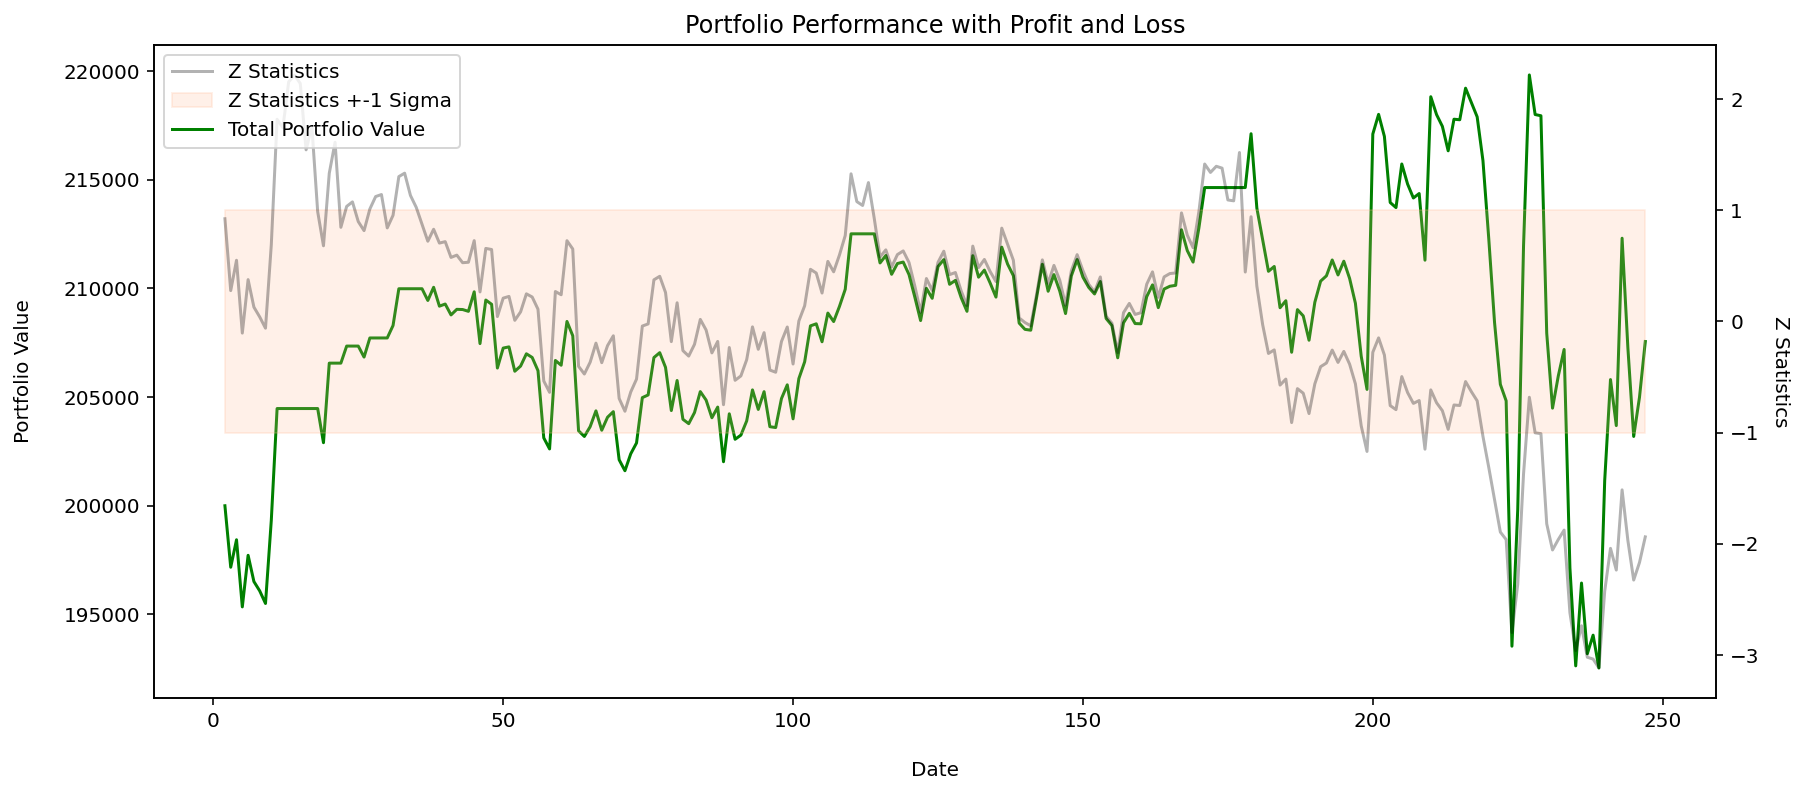

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

207556.504125

In [48]:
profit = final_portfolio - 2*initial_capital
profit

7556.504125000007

In [49]:
roi = (profit/(2*initial_capital))*100
roi

3.778252062500003

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 196.803%
